# Surface Defect Detection for Korea Dataset

## 1. Introduction

In this notebook, we are going to create a convolutional neural network (CNN) that can detect surface defects.
Previously we have used Torch but now PyTorch will be used.

PyTorch is the freshest flavour of the Torch. It combines customization of Torch with Python ease of use. It completely covers the Torch functionality, on top of that, new Autograd mechanism, dataset loaders and lots of utilities have been added for convenience.

## 2. Code

First, let's import required packages...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.init as init
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Spectral7
from bokeh.io import output_notebook
#from graphviz import Digraph
import numpy as np
import cnnUtils
import time
import copy
import os
import PIL
from pympler import muppy
%matplotlib inline
plt.ion()
output_notebook()

Please install sklearn for layer visualization


Loading BokehJS ...

## 2.1 Dataset transformations
PyTorch lets us define a set of transformations to the loaded datasets. 

First images are converted to Torch tensors and then we will be scaling the images to 64 pixels in the smaller dimension. 

In [2]:
baseDirectory = 'g:/Selim/Thesis/Code/'
setDirectory = 'KR2'
setImageSize = 128

# Inceptionv3 requires 3x299x299

# KR1 full mean and std
#Dim 0 mean: 0.422863536557
#Dim 0 stdv: 0.0630701124376

# KR2 
#Dim 0 mean: 0.425628425212
#Dim 0 stdv: 0.0511853708183

setMean = [0.425, 0.425, 0.425]
setStd = [0.051, 0.051, 0.051]

dataTransforms = {
    'train': transforms.Compose([
        transforms.Scale((setImageSize,setImageSize)),
        #transforms.CenterCrop(setImageSize),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
    'test': transforms.Compose([
        transforms.Scale((setImageSize,setImageSize)),
        #transforms.CenterCrop(setImageSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
}

## 2.2 Loading datasets
Unlike Torch, PyTorch now supports direct image folder loading as the data. This completely removes the big dataset preparation step.

Additionally new dataset loaders allow setting batch size, shuffle and several other useful parameters.

Lastly checking the CUDA support is now easier with `torch.cuda.is_available()`

In [4]:
setPath = os.path.join(baseDirectory, setDirectory)
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(setPath, x), dataTransforms[x])
           for x in ['train', 'test']}

datasetLoaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=64, shuffle=True, num_workers=4)
                for x in ['train', 'test']}

testLoader = torch.utils.data.DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=4)

datasetSizes = {x: len(datasets[x]) for x in ['train', 'test']}
datasetClasses = datasets['train'].classes

useGPU = torch.cuda.is_available()

print(str(datasetSizes) + ' images will be used.' )
print('GPU will ' + ('' if useGPU else 'not ') + 'be used.' )
print('Output will be ' + str(len(datasetClasses)) + ' classes')

{'train': 1991, 'test': 1781} images will be used.
GPU will be used.
Output will be 17 classes


## 2.3 Auxiliary functions

### 2.3.1 ImShow
Here we define the simple image displaying function and use the new dataset iterator to get one random batch to display it.

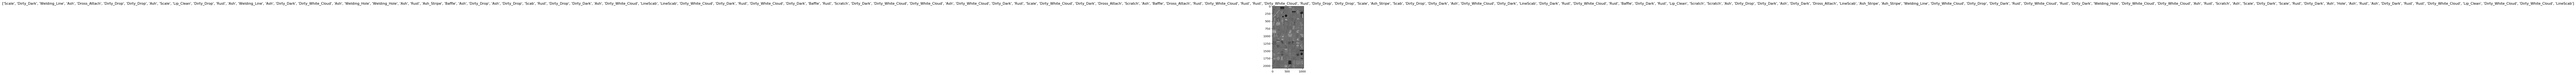

In [4]:
inputs, classes = next(iter(datasetLoaders['train']))
out = torchvision.utils.make_grid(inputs)

cnnUtils.ImShow(out, mean=setMean, std=setStd, title=[datasetClasses[x] for x in classes])
#print(inputs)

# 2.4 Training functions

This section contains functions used in training the network. First we should create the arrays to keep the error and learning rate changes.

In [5]:
trainLRValues = []
trainAccuracyTrain = []
trainAccuracyTest = []
trainErrorTrain = []
trainErrorTest = []

grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

## 2.5 Definition of neural network

### 2.5.1 Network module
Similar to Torch, here we define the neural network using separate modules.
First module handles the convolutional part of the network. After that a reshape operation adjust the convolution result for the following fully-connected layer module. Lastly, the result is applied to the fully-connected layer of the network and decisions are obtained with LogSoftMax operation in the end.

In [6]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        self.convI3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(convInResult))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(convI2Result))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(convI3Result))
        
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x



#### 2.5.1.2 Batch normalization - TEST

In [7]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class NetBN(nn.Module):
    def __init__(self):
        super(NetBN, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNI2 = nn.BatchNorm2d(num_features=32)
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        self.convI3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(self.batNIn(convInResult)))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(self.batNI2(convI2Result)))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(self.batNI3(convI3Result)))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

#### 2.5.1.4 Batch normalization + SELU + AlphaDropout

In [8]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class NetBNSELU(nn.Module):
    def __init__(self):
        super(NetBNSELU, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.seluIn = cnnUtils.SELU()
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNI2 = nn.BatchNorm2d(num_features=64)
        self.seluI2 = cnnUtils.SELU()
        
        # Out CH = 32 !
        self.convI3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.seluI3 = cnnUtils.SELU()
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 1024),
            cnnUtils.SELU(),
            cnnUtils.AlphaDropout(p=0.5),
            nn.Linear(1024, 1024),
            cnnUtils.SELU(),
            cnnUtils.AlphaDropout(p=0.5),
            nn.Linear(1024, 1024),
            cnnUtils.SELU(),
            #cnnUtils.AlphaDropout(p=0.5),
            nn.Linear(1024, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.seluIn(self.batNIn(convInResult))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.seluI2(self.batNI2(convI2Result))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.seluI3(self.batNI3(convI3Result))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

#### 2.5.1.5 BN + Optim

In [9]:
class NetBNOptim(nn.Module):
    def __init__(self):
        super(NetBNOptim, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.batNI2 = nn.BatchNorm2d(num_features=64)
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        # Out CH = 32 !
        self.convI3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(self.batNIn(convInResult)))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(self.batNI2(convI2Result)))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(self.batNI3(convI3Result)))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

In [10]:
def GetMatchingLayer(inChannels, outChannels, stride=(2,2), padding=(0,0)):
    return nn.Sequential(
            nn.Conv2d(in_channels=inChannels, out_channels=outChannels, kernel_size=(1,1), stride=stride, padding=padding),
            #nn.BatchNorm2d(num_features=outChannels)
    ).cuda()

class DSPlusNet(nn.Module):
    def __init__(self):
        super(DSPlusNet, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.reluIn = nn.ReLU()
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNI2 = nn.BatchNorm2d(num_features=64)
        self.reluI2 = nn.ReLU()
        
        # Out CH = 32 !
        self.convI3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.reluI3 = nn.ReLU()
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5),
            nn.Linear(1024, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        #  Get the residual, match it to the output
        #plus01 = GetMatchingLayer(self.convIn.in_channels, self.convIn.out_channels)(x)
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        #  Add the residual before activation function
        x = self.reluIn(self.batNIn(convInResult)) #  + plus01
        
        # Convolutional layer 2
        #  Get the residual, match it to the output
        #plus02 = GetMatchingLayer(self.convI2.in_channels, self.convI2.out_channels)(x)
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        #  Add the residual before activation function
        x = self.reluI2(self.batNI2(convI2Result)) # + plus02
        
        # Convolutional layer 3
        #  Get the residual, match it to the output
        #plus03 = GetMatchingLayer(self.convI3.in_channels, self.convI3.out_channels)(x)
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        #  Add the residual before activation function
        x = self.reluI3(self.batNI3(convI3Result)) #  + plus03
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

#### DSMNLNet

In [11]:
class DSMNLNet(nn.Module):
    def __init__(self):
        super(DSMNLNet, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNIn = nn.BatchNorm2d(num_features=64)
        self.reluIn = nn.ReLU()
        
        self.convIA = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,1), stride=(1,1), padding=(0,0), dilation=(3,3))
        self.batNIA = nn.BatchNorm2d(num_features=64)
        self.reluIA = nn.ReLU()
                
        self.convI2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNI2 = nn.BatchNorm2d(num_features=128)
        self.reluI2 = nn.ReLU()
        
        self.convIB = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1,1), stride=(1,1), padding=(0,0), dilation=(3,3))
        self.batNIB = nn.BatchNorm2d(num_features=128)
        self.reluIB = nn.ReLU()
        
        # Out CH = 32 !
        self.convI3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(5,5), stride=(2,2), padding=(6,6), dilation=(3,3))
        self.batNI3 = nn.BatchNorm2d(num_features=256)
        self.reluI3 = nn.ReLU()
        
        self.convIC = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1,1), stride=(1,1), padding=(0,0), dilation=(3,3))
        self.batNIC = nn.BatchNorm2d(num_features=256)
        self.reluIC = nn.ReLU()
        
        # Extended nonlinearity
        self.convI4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1,1), stride=(1,1), padding=(0,0), dilation=(3,3))
        self.batNI4 = nn.BatchNorm2d(num_features=256)
        self.reluI4 = nn.ReLU()
        
        self.convI5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1,1), stride=(1,1), padding=(0,0), dilation=(3,3))
        self.batNI5 = nn.BatchNorm2d(num_features=256)
        self.reluI5 = nn.ReLU()
        
        self.convI6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1,1), stride=(1,1), padding=(0,0), dilation=(3,3))
        self.batNI6 = nn.BatchNorm2d(num_features=256)
        self.reluI6 = nn.ReLU()
            
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(256 * self.outMul * self.outMul, len(datasetClasses)))
            #nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5),
            #nn.Linear(4096, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        #  Get the residual, match it to the output
        #plus01 = GetMatchingLayer(self.convIn.in_channels, self.convIn.out_channels)(x)
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        #  Add the residual before activation function
        x = self.reluIn(self.batNIn(convInResult)) #  + plus01
        
        x = self.reluIA(self.batNIA(self.convIA(x)))
        
        # Convolutional layer 2
        #  Get the residual, match it to the output
        #plus02 = GetMatchingLayer(self.convI2.in_channels, self.convI2.out_channels)(x)
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        #  Add the residual before activation function
        x = self.reluI2(self.batNI2(convI2Result)) # + plus02
        
        x = self.reluIB(self.batNIB(self.convIB(x)))
        
        # Convolutional layer 3
        #  Get the residual, match it to the output
        #plus03 = GetMatchingLayer(self.convI3.in_channels, self.convI3.out_channels)(x)
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        #  Add the residual before activation function
        x = self.reluI3(self.batNI3(convI3Result)) #  + plus03
        
        x = self.reluIC(self.batNIC(self.convIC(x)))
        
        x = self.reluI4(self.batNI4(self.convI4(x)))
        x = self.reluI5(self.batNI5(self.convI5(x)))
        x = self.reluI6(self.batNI6(self.convI6(x)))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 256 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

Now let's initialize the network and use GPU if possible.

In [12]:
# Regular net
#net = Net()

# Net with batch normalization layers, added approx ~1m per 10 epochs
#net = NetBN()

# Net with BN + SELU + AlphaDropout
#net = NetBNSELU()

# A smaller Net with batch normalization
#net = NetSmallBN()

# BN with optimized params
#net = NetBNOptim()

#net = DSPlusNet()

net = DSMNLNet()

# ResNet50
#net = models.resnet50(pretrained=True)
# Adapt FC layer for our class output
#net.fc.out_features = len(datasetClasses)
#print(net.fc)

# Inceptionv3 : Pain in the ass, have to change train function and add losses manually. Ignored for now
####net = models.inception_v3(pretrained=True)

if useGPU:
    net = net.cuda()

### 2.5.2 Criterion and optimizer
We successfully created our neural network. Now it is time to define a loss function and the optimizer.

In [13]:
# CrossEntropy already contains logsoftmax, use NLL
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

# try 0.03 weight_decay
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001, nesterov=True)
#optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.01) #default: lr=0.0001

lrScheduler = cnnUtils.StepLR(optimizer, step_size=5, gamma=0.5)

if useGPU:
    criterion = criterion.cuda()

In [13]:
allObjects = muppy.get_objects()
print(len(allObjects))

243687


## 2.6 Training

Mini-batch training method is preferred with PyTorch. It converges faster than the batch training method.

*Example*

*Mini-batch : With GTX 1070, 50 epochs train in 6m8s with 92.1% train and 93.9% test accuracy.*

*Batch      : With GTX 1070, 80 epochs train in 7m32s with 98.5% train and 99.3% test accuracy.*

In [14]:
cnnUtils.TrainModelMiniBatch(net, criterion, optimizer, lrScheduler, datasetLoaders, datasetSizes, trainAccuracyTrain, trainAccuracyTest, trainLRValues, 
                    trainErrorTrain, trainErrorTest, num_epochs=50)   

Epoch 0/49
----------
LR: [0.002]
train Loss: 0.0309 Acc: 0.3842
test Loss: 0.0549 Acc: 0.0646

Epoch 1/49
----------
LR: [0.001]
train Loss: 0.0184 Acc: 0.6419
test Loss: 0.0689 Acc: 0.0724

Epoch 2/49
----------
LR: [0.001]
train Loss: 0.0118 Acc: 0.7986
test Loss: 0.0738 Acc: 0.1061

Epoch 3/49
----------
LR: [0.001]
train Loss: 0.0071 Acc: 0.9126
test Loss: 0.0732 Acc: 0.1084

Epoch 4/49
----------
LR: [0.001]
train Loss: 0.0042 Acc: 0.9674
test Loss: 0.0880 Acc: 0.0870

Epoch 5/49
----------
LR: [0.001]
train Loss: 0.0026 Acc: 0.9955
test Loss: 0.0906 Acc: 0.1005

Epoch 6/49
----------
LR: [0.0005]
train Loss: 0.0025 Acc: 0.9930
test Loss: 0.0917 Acc: 0.0736

Epoch 7/49
----------
LR: [0.0005]
train Loss: 0.0018 Acc: 0.9985
test Loss: 0.0944 Acc: 0.0831

Epoch 8/49
----------
LR: [0.0005]
train Loss: 0.0015 Acc: 0.9980
test Loss: 0.0983 Acc: 0.0769

Epoch 9/49
----------
LR: [0.0005]
train Loss: 0.0014 Acc: 0.9985
test Loss: 0.0994 Acc: 0.0786

Epoch 10/49
----------
LR: [0.0005]


KeyboardInterrupt: 

In [15]:
torch.save(net.state_dict, 'eba5state.netsta') 

##Load
#model.load_state_dict(checkpoint['state_dict'])

g:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\serialization.py:147: UserWarning: Couldn't retrieve source code for container of type DSPlusNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
from pympler import summary
print(len(allObjects))
sum1 = summary.summarize(allObjects)
summary.print_(sum1)

allObjects2 = muppy.get_objects()
print(len(allObjects2))
sum2 = summary.summarize(allObjects2)
summary.print_(sum2)

244562
                               types |   # objects |   total size
==================================== | =========== | ============
                         <class 'str |       88557 |     12.28 MB
                        <class 'dict |       17615 |      6.53 MB
                        <class 'code |       23152 |      3.18 MB
                        <class 'type |        3056 |      3.13 MB
                         <class 'set |        2913 |      1.37 MB
                        <class 'list |       12993 |      1.37 MB
                       <class 'tuple |       12359 |    821.52 KB
                     <class 'weakref |        5691 |    444.61 KB
           <class 'method_descriptor |        5735 |    403.24 KB
                 function (__init__) |        1997 |    265.23 KB
                 <class 'abc.ABCMeta |         227 |    228.97 KB
       <class 'bokeh.model.MetaModel |         218 |    226.44 KB
  <class 'torch._thnn.utils.Argument |        4101 |    224.27 KB
   

In [13]:
#TrainModelBatch(net, criterion, optimizer, 0.000011875, maxIteration=80)

NetBNOptim (
  (convIn): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batNIn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (reluIn): ReLU ()
  (poolIn): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (convI2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batNI2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (reluI2): ReLU ()
  (poolI2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (convI3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batNI3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (reluI3): ReLU ()
  (poolI3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc): Sequential (
    (0): Linear (8192 -> 1024)
    (1): ReLU ()
    (2): Dropout (p = 0.5, inplace)
    (3): Linear (1024 -> 1024)
    (4): ReLU ()
    (5): Dropout (p = 0.5, inplace)
    (6): Linear (1024 -> 1024)
    (7): ReLU ()
    (8): Dropout (p = 0.5, inplace)
    (9): Linear (10

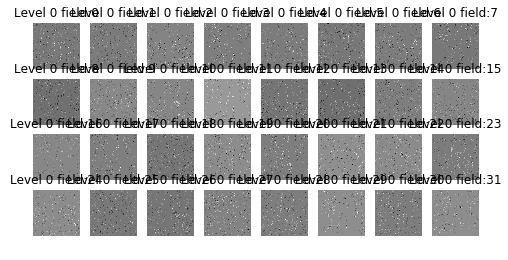

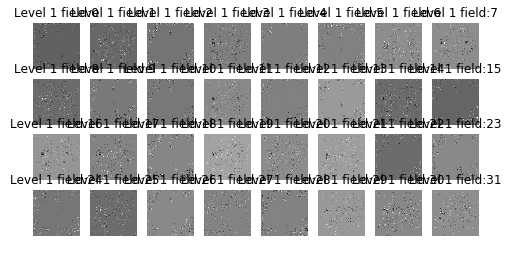

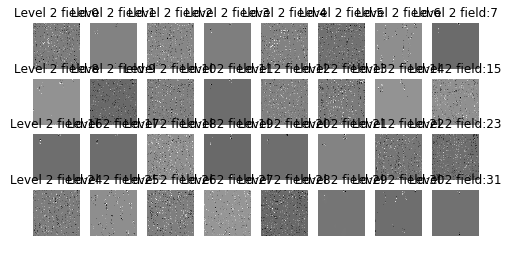

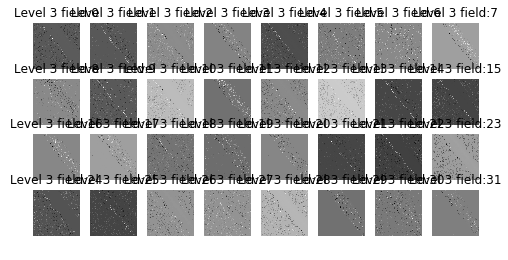

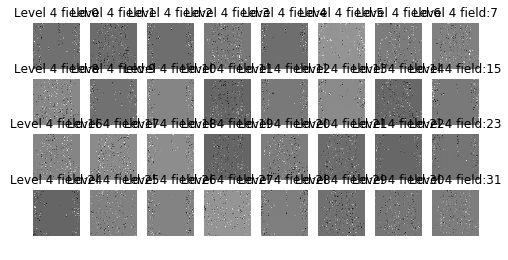

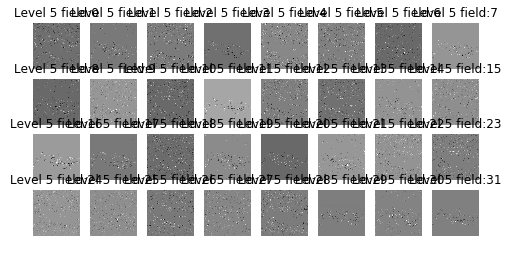

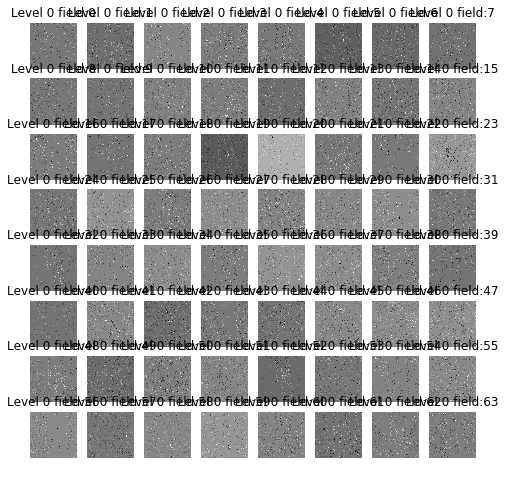

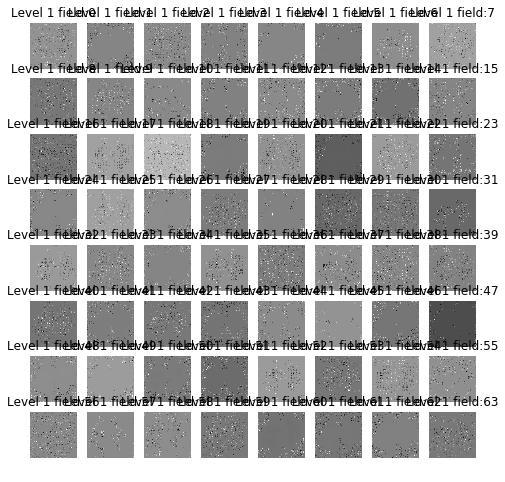

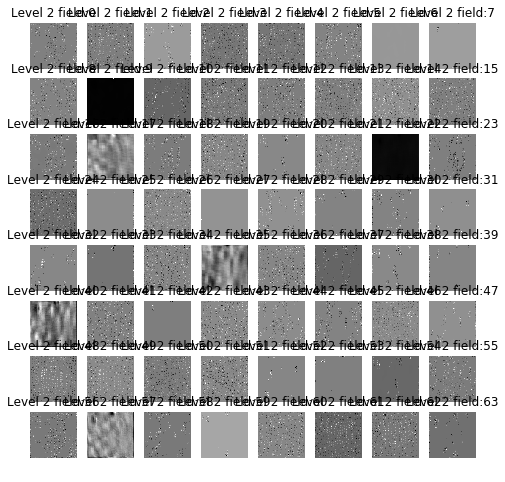

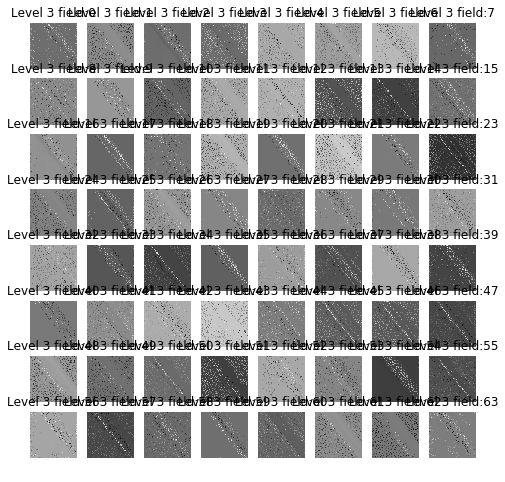

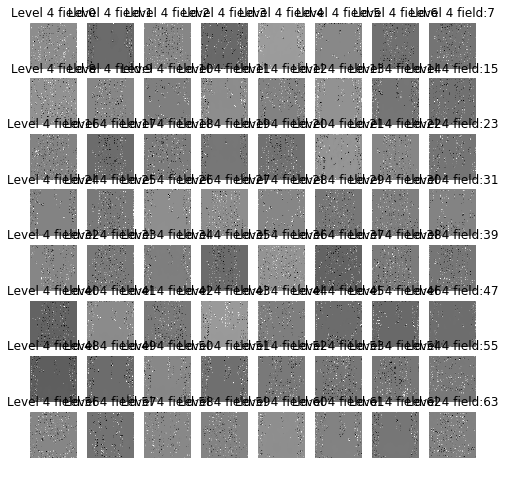

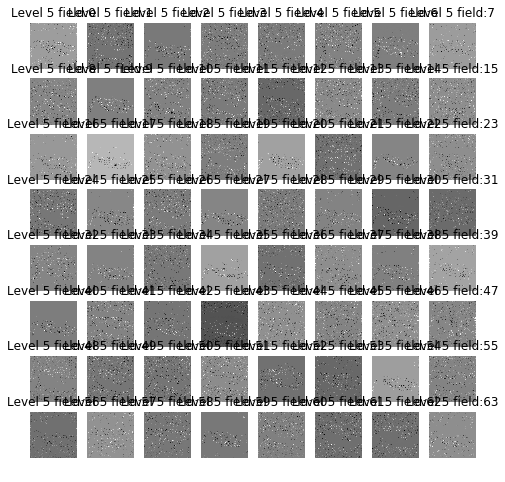

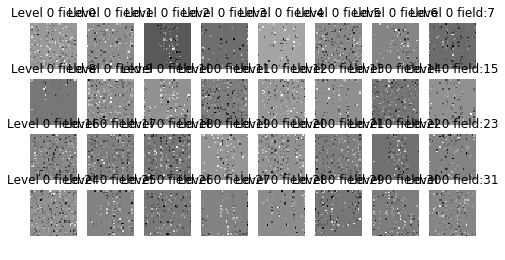

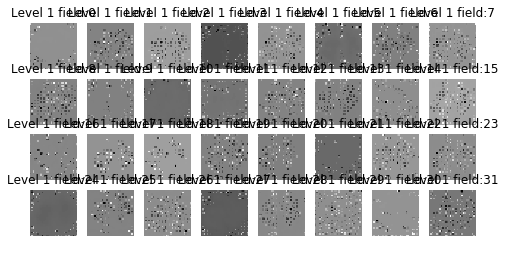

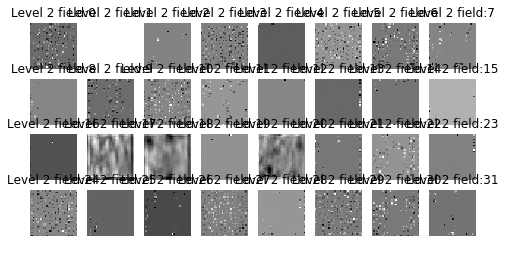

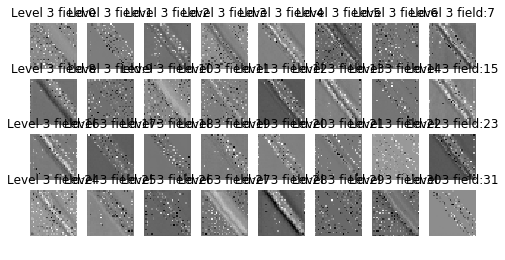

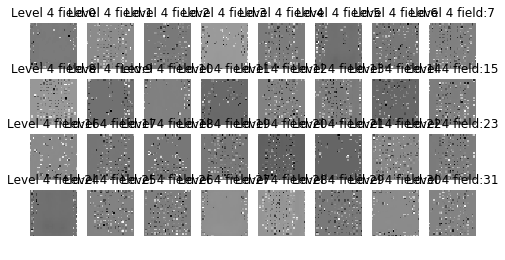

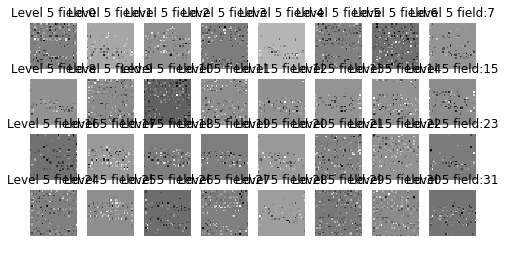

In [16]:
print(net)
gradIn = grads['convInGrad']
gradI2 = grads['convI2Grad']
gradI3 = grads['convI3Grad']

def PlotActivationMaps(gradients):
    for iT in range(gradients.size()[0]):
        plt.figure(figsize=(8, 8))
        for z in range(gradients.size()[1]):
            plt.subplot(8, 8, z+1)
            plt.title('Level ' + str(iT) + ' field:' + str(z))
            plt.axis('off')
            plt.pause(0.001)
            plt.imshow(gradients[iT, z, :, :].data.cpu().numpy(), interpolation='nearest', cmap='gray')
PlotActivationMaps(gradIn)
PlotActivationMaps(gradI2)
PlotActivationMaps(gradI3)

### 2.6.3 Visualization of the progress

In [16]:
def PlotArrays(arrays, labels, xlabel, ylabel, title):
    p = figure(title=title, x_axis_label=xlabel, y_axis_label=ylabel)
    length = len(arrays[0])
    palette = Spectral7[0:len(arrays)]
    x = np.linspace(0, length - 1, length)
    i = 0
    
    for array, label in zip(arrays, labels):
        p.circle(x, array, legend=label, fill_color=palette[i], line_color=palette[i])
        p.line(x, array, legend=label, line_color=palette[i], line_width=2)
        i += 1
    
    p.legend.location = 'bottom_left'
    show(p)

PlotArrays([trainErrorTrain, trainErrorTest], ['Training', 'Test'], xlabel='Epoch', ylabel='Loss', title='Loss over epoch')
PlotArrays([trainLRValues], ['Learning rate'], xlabel='Epoch', ylabel='Learning rate', title='Learning rate decrease')
PlotArrays([trainAccuracyTrain, trainAccuracyTest], ['Training accuracy', 'Test accuracy'], xlabel='Epoch', ylabel='Accuracy', title='Accuracy increase over epoch')

## 2.7 Visualization of the weights

This section is still in development.

In [30]:
#VisualizeModel(net)

In [31]:
# IN PROGRESS...
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
#plot_kernels(net.conv[6].weight.cpu().data.numpy())

In [34]:
import math
def plotNNFilter(units):
    print(units.shape)
    filters = units.shape[0]
    plt.figure(1, figsize=(6,6))
    
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        #plt.title('Filter ' + str(i))
        plt.axis('off')
        plt.imshow(units[i,0,:,:], interpolation="nearest", cmap="gray")

(32, 3, 5, 5)


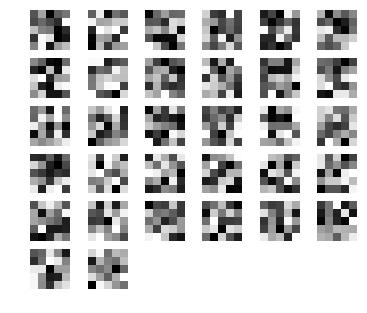

In [35]:
plotNNFilter(net.convIn.weight.cpu().data.numpy())

## 2.8 Evaluating network accuracy
Let's calculate the accuracy on the training set.

In [37]:
def DetermineAccuracy(phase):
    correct = 0
    total = 0
    for data in datasetLoaders[phase]:
        # Inputs
        inputs, labels = data
        if useGPU:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    return correct, total

In [38]:
correct, total = DetermineAccuracy('train')
print('Accuracy of the network for training set is {}%'.format(100 * correct / total))

Accuracy of the network for training set is 66.39209225700165%


Now time to see the accuracy of the test set.

In [39]:
correct, total = DetermineAccuracy('test')
print('Accuracy of the network for test set is {}%'.format(100 * correct / total))

Accuracy of the network for test set is 65.91639871382637%


Let's see individual class performance along with the confusion matrix.

Class defect total: 181.0 correct: 177.0 success rate is 97.79005524861878
Class nonDefect total: 130.0 correct: 129.0 success rate is 99.23076923076923


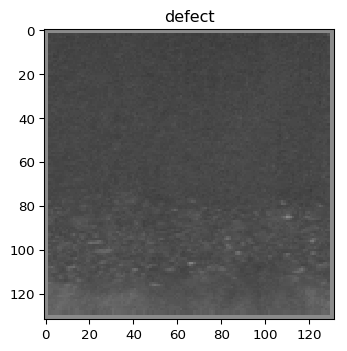

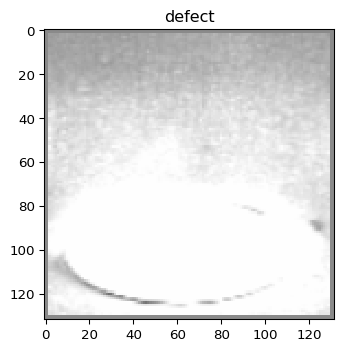

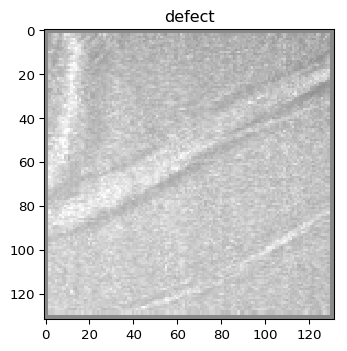

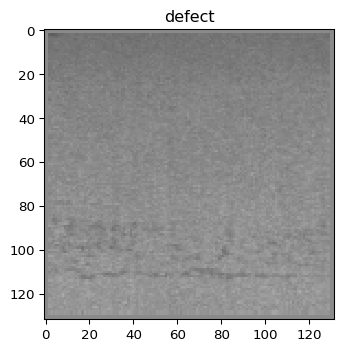

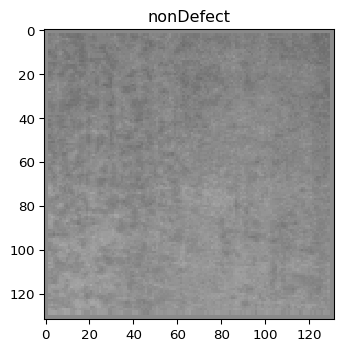

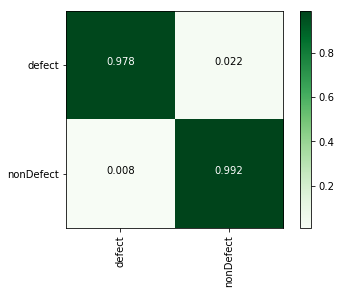

In [29]:
classCorrect = list(0. for i in range(2))
classTotal = list(0. for i in range(2))
confusion = torch.zeros(2, 2)

for i, data in enumerate(testLoader):
    inputs, labels = data
    if useGPU:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)

    classTotal[labels.data.cpu().numpy()[0]] += 1
    confusion[labels.data.cpu().numpy()[0]][predicted[0][0]] += 1
    
    if labels.data.cpu().numpy()[0] == predicted.cpu().numpy()[0][0]:
        classCorrect[labels.data.cpu().numpy()[0]] += 1
    else: # Display failure cases
        out = torchvision.utils.make_grid(inputs.data.cpu())
        ImShow(out, mean=setMean, std=setStd, title=datasetClasses[labels.data.cpu()[0]])

for i, cls in enumerate(classCorrect):
    print('Class ' + datasetClasses[i] + ' total: ' + str(classTotal[i]) + ' correct: ' + str(classCorrect[i]) + ' success rate is ' + str(100 * classCorrect[i] / classTotal[i])) 

    
# Normalize confusion matrix
for i in range(2):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Plot confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
#cax = ax.matshow(confusion.numpy())
plt.imshow(confusion.numpy(), interpolation='nearest', cmap=plt.cm.Greens)
plt.colorbar()

ax.set_xticklabels([''] + datasetClasses, rotation=90)
ax.set_yticklabels([''] + datasetClasses)
thresh = confusion.max() / 2.0

for i in range(confusion.numpy().shape[0]):
    for j in range(confusion.numpy().shape[1]):
        plt.text(j, i, np.around(confusion[i,j], 3), horizontalalignment="center", color="white" if confusion[i, j] > thresh else "black")

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Results are looking good, let's save the model for future use.

In [27]:
torch.save(net, 'EBA5CNN.net')

g:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\serialization.py:147: UserWarning: Couldn't retrieve source code for container of type NetBN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [28]:
netb = torch.load('EBACNN.net')

In [30]:
input, label = next(iter(datasetLoaders['train']))
input, label = Variable(input.cuda()), Variable(label.cuda())

startT = time.perf_counter()
outputs = net(input)
endT = time.perf_counter()
_, predicted = torch.max(outputs.data, 1)
    
print(str((endT-startT) * 1000)  + ' ms')

3.894154591885357 ms
